In [48]:
%matplotlib inline
import numpy as np
import sys
sys.path.append("../tsy935/RubinLab_neurotranslate_eeg-master/eeg/")
sys.path.append("../tsy935/RubinLab_neurotranslate_eeg-master/eeg/data/")
from data_loader_estimated import EstimatedDataset
from data_loader import SeizureDataset
import torch
import math
import matplotlib.pyplot as plt
sys.path.append("../add_noise/")
from add_noise_manual import AddNoiseManual

In [117]:
noise_adder = AddNoiseManual(b=1e4)
def add_noise(img):
    print("adding noise")
    img_noisy = noise_adder(img)
    return img_noisy

In [108]:
def compute_div_spec(raw_noisy, transpose=True):
    # tranpose switches channels from last to first
    div_spec_noisy = torch.FloatTensor([EstimatedDataset.compute_div_spec(raw_noisy_sample) for raw_noisy_sample in raw_noisy])
    if transpose:
        div_spec_noisy = div_spec_noisy.transpose(1, 3) #[:4, :, :, :]
    div_spec_noisy = torch.nn.functional.pad(input=div_spec_noisy, pad=(0,0, 16,16, 0,0, 0,0), mode='constant', value=0)
    return div_spec_noisy

In [109]:
def normalize(batch):
    batch = batch - batch.mean()
    batch = batch / batch.std()
    batch = batch / np.abs(batch).max()
    return batch

In [52]:
train_dataset = EstimatedDataset(8)
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    shuffle=True,
    batch_size=2,
)

    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
Reading forward solution from /mnt/home2/dlongo/eegML/forward_model/sample_forward_model...
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Changing to fixed-orientation forward solution with surface-based source orientations...
    [done]


/mnt/home2/dlongo/eegML/data_loaders/forward_model_dataloader.py:60: RuntimeWarning: This filename (/mnt/home2/dlongo/eegML/forward_model/sample_forward_model) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  fwd = mne.read_forward_solution("/mnt/home2/dlongo/eegML/forward_model/sample_forward_model")


Projecting source estimate to sensor space...
[done]
Projecting source estimate to sensor space...
[done]
Projecting source estimate to sensor space...
[done]
Projecting source estimate to sensor space...
[done]
Projecting source estimate to sensor space...
[done]
Projecting source estimate to sensor space...
[done]
Projecting source estimate to sensor space...
[done]
Projecting source estimate to sensor space...
[done]


In [53]:
train_loader_seizure = torch.utils.data.DataLoader(
    dataset=SeizureDataset(),
    shuffle=True,
    batch_size=2,
)

file dir:/mnt/home2/dlongo/eegML/tsy935/RubinLab_neurotranslate_eeg-master/eeg/data/trainSet_seizure_files.txt
/mnt/home2/dlongo/input/nonOverlap/train_features.h5


In [54]:
#For real from Temple Dataset
# list (2, 9, 3, 224, 224)
for a in train_loader_seizure:
    x = a
    break

# For esitmated 
for a, c in train_loader:
    raw = a
    div_spec = c 

In [55]:
x[0].shape
div_spec.shape

torch.Size([2, 224, 224, 3])

#### Pad and normalize div spec already generated

In [85]:
div_spec_clean = div_spec.transpose(1, 3) #view(2 * 1, 3, 224, 224)[:4, :, :, :]
div_spec_clean = torch.nn.functional.pad(input=div_spec_clean, pad=(0,0, 16,16, 0,0, 0,0), mode='constant', value=0)
div_spec_clean = normalize(div_spec_clean)
div_spec_clean_sample = div_spec_clean[0].numpy()
div_spec_clean_sample.shape

(3, 256, 224)

#### Convert Clean Raw Data to Div Spec 

In [86]:
raw_converted = compute_div_spec(raw.clone())
raw_converted = normalize(raw_converted)
raw_converted_sample = raw_converted[0].numpy()
raw_converted_sample.shape

(3, 256, 224)

#### Add noise to Clean Raw Data and then convert to Div Spec

In [110]:
np.sum(np.abs(raw.numpy()))

175044060.0

In [118]:
assert(np.sum(np.abs(raw.numpy())) > 1 and np.sum(np.abs(raw.numpy())) < 1e10000000), "Invalid Sum"
source = raw.clone()
noisy_raw = torch.FloatTensor([add_noise(raw_sample) for raw_sample in source])
# print("noisy_raw", noisy_raw.shape, np.sum(np.abs(noisy_raw.numpy())))
div_spec_noisy = compute_div_spec(noisy_raw)
# print("converted noisy raw", div_spec_noisy.shape)
div_spec_noisy = normalize(div_spec_noisy)
div_spec_noisy_sample = div_spec_noisy[0].numpy()
div_spec_noisy_sample.shape

adding noise
adding noise


(3, 256, 224)

In [60]:
def view_sample(x):
    #input shape (3, s, s)
    if x.shape[2] != 3:
        x = x.T
    print("x shape", x.shape)
    assert(len(x.shape) == 3), "Input should be three dimensional"
    assert(x.shape[2] == 3), "input should have three channels"
    imgplot = plt.imshow(x)
    

In [61]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))
sigmoid_v = np.vectorize(sigmoid)

In [141]:
# sample = div_spec_clean_sample
sample = raw_converted_sample
# sample = div_spec_noisy_sample

In [142]:
np.sum(np.abs(sample))

46061.69

In [140]:
np.sum(np.abs(sample))

48442.254

In [137]:
np.sum(np.abs(raw_converted_sample - div_spec_noisy_sample))

15262.517

In [138]:
sample.shape

(3, 256, 224)

x shape (224, 256, 3)


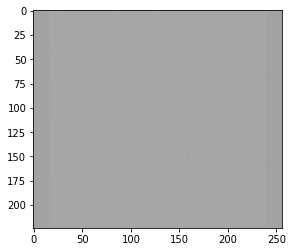

In [139]:
normalize_sample = False
sig = True
if normalize_sample:
    show = normalize(sample)
    
if sig:
    show = sigmoid_v(show)
    
else:
    show = sample
    
if type(show) != np.ndarray:
    show = sample.numpy()
    
view_sample(show)

Original

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


x shape (224, 256, 3)


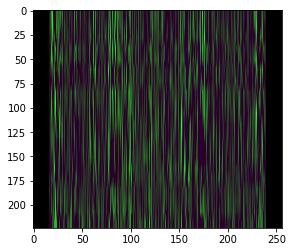

In [126]:
view_sample(show)

Added Noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


x shape (224, 256, 3)


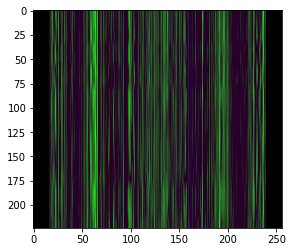

In [124]:
view_sample(show)